In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
!unzip -q /content/gdrive/My\ Drive/simpsons/data/simpsons4.zip

In [3]:
!ls train

simpsons_dataset


In [0]:
import os
import glob
import copy
import shutil
import pickle
import random
import numpy as np
import pandas as pd
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

from matplotlib import colors, pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [0]:
# фиксируем генераторы случайных чисел для получения сравнимых результатов

random.seed(383)
np.random.seed(383)
torch.manual_seed(383)
torch.cuda.manual_seed(383)
torch.backends.cudnn.deterministic = True

In [0]:
# Hyperparameters

lr =    1e-5
batch = 32
epoch = 3

In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [0]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
    
    def __getitem__(self, index):
        # для тренировочной выборки используем аугментацию, для тестовой и валидационной -- нет
        # потом изображения во всех выборках преобразовываем в тензоры и нормализуем
        train_transform = transforms.Compose([
            transforms.RandomRotation(degrees=10),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.2),
            transforms.RandomHorizontalFlip(),                  # p=0.5 is default
        ])
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
            x = train_transform(x)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

### В этом блоке создаём временную директорию, куда копируем все каталоги-классы из simpsons_dataset
При этом,

- сначала балансируем классы так, чтобы количество изображений в каждом каталоге-классе было сравнимо с количеством изображений в самом большом каталоге homer_simpson
- затем увеличиваем количество изображений в каждом каталоге-классе копированием в 3 раза

In [11]:
if not os.path.exists('temp'):
    os.makedirs('temp')

    f = list(os.walk(TRAIN_DIR))
    rng = len(f[0][1])
    f[0][1][1], f[2]
    fmap = {}
    for i in range(rng):
        fmap[f[0][1][i]] = len(f[i+1][2])
    maximum = max(fmap.values())
    for key in fmap:
    #     r = maximum//fmap[key]
    #     fmap[key] = 1 if r < 15 else 10
        fmap[key] = 3*(maximum//fmap[key])
        # fmap[key] = maximum//fmap[key]+1

    for class_name in fmap:
        source_dir = os.path.join(TRAIN_DIR, class_name)
        os.makedirs(os.path.join('temp', class_name))
        for idx in range(fmap[class_name]):
            for file_name in os.listdir(source_dir):
                dest_dir = os.path.join('temp', class_name)
                shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, str(idx)+file_name))
fmap

{'abraham_grampa_simpson': 6,
 'agnes_skinner': 159,
 'apu_nahasapeemapetilon': 9,
 'barney_gumble': 63,
 'bart_simpson': 3,
 'carl_carlson': 66,
 'charles_montgomery_burns': 3,
 'chief_wiggum': 6,
 'cletus_spuckler': 141,
 'comic_book_guy': 12,
 'disco_stu': 840,
 'edna_krabappel': 12,
 'fat_tony': 249,
 'gil': 249,
 'groundskeeper_willie': 54,
 'homer_simpson': 3,
 'kent_brockman': 12,
 'krusty_the_clown': 3,
 'lenny_leonard': 21,
 'lionel_hutz': 2244,
 'lisa_simpson': 3,
 'maggie_simpson': 51,
 'marge_simpson': 3,
 'martin_prince': 93,
 'mayor_quimby': 27,
 'milhouse_van_houten': 6,
 'miss_hoover': 396,
 'moe_szyslak': 3,
 'ned_flanders': 3,
 'nelson_muntz': 18,
 'otto_mann': 210,
 'patty_bouvier': 93,
 'principal_skinner': 3,
 'professor_john_frink': 102,
 'rainier_wolfcastle': 147,
 'ralph_wiggum': 75,
 'selma_bouvier': 63,
 'sideshow_bob': 6,
 'sideshow_mel': 168,
 'snake_jailbird': 120,
 'troy_mcclure': 840,
 'waylon_smithers': 36}

In [0]:
# меняем path для TRAIN_DIR на вновь созданную директорию

TRAIN_DIR = Path('temp')

In [0]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [0]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, \
                                          stratify=train_val_labels)

In [15]:
val_idxs = len(val_files)
len(train_files), len(val_files)

(199795, 49949)

In [0]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Давайте посмотрим на наших героев внутри датасета.

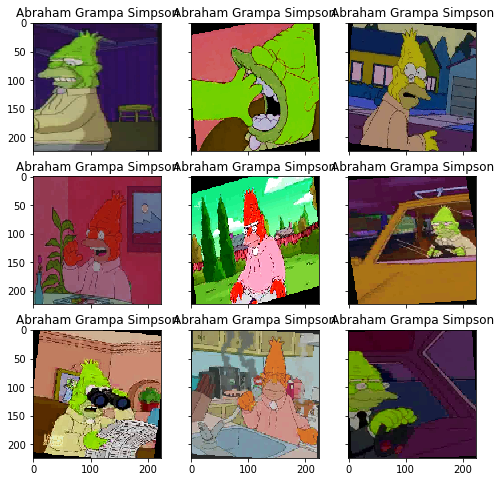

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [18]:
# используем pretrained CNN DenseNet161 для классификации изображений
# в ней изменим конфигурацию оригинального классификатора, чтобы он работал с 42 классами

n_classes = len(np.unique(train_val_labels))
model_rn = models.densenet161(pretrained=1)

model_rn.classifier = nn.Linear(in_features=2208, out_features=n_classes, bias=True) # densenet161
    
model_rn = model_rn.to(DEVICE)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:02<00:00, 46.2MB/s]


In [0]:
def mean_f1_score(y, y_pred):
    '''рвссчет метрики mean f1'''
    epsylon = 1e-11

    cnf_matrix = confusion_matrix(y, y_pred)

    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)

    FP = FP.astype(float)+epsylon
    FN = FN.astype(float)+epsylon
    TP = TP.astype(float)+epsylon
    TN = TN.astype(float)+epsylon

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)

    f1_score = 2*precision*recall/(precision+recall)
    return f1_score.mean()

In [0]:
def fit_epoch(model, train_loader, criterion, optimizer):
    '''функция для расчета accuracy и loss для выборки train'''
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [0]:
def eval_epoch(model, val_loader, criterion):
    '''функция для расчета accuracy и loss для выборки validation'''
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [0]:
def train(train_files, val_files, model, epochs, batch_size):
    '''функция для тренировки модели'''
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # лучшую модель выбираем, исходя из наибольшего соотношения val_acc/val_loss по эпохам
    best_model = copy.deepcopy(model.state_dict())
    best_score, best_epoch = 0.0, 0

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            if val_acc/val_loss > best_score:
                best_score, best_epoch = val_acc/val_loss, epoch
                best_model = copy.deepcopy(model.state_dict())

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    print('best_epoch:', best_epoch)
    # для предсказаний будет использоваться лючшая модель
    model.load_state_dict(best_model)
    return history

In [0]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

## Запустим обучение сети.

In [0]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

if train_dataset is None:
    train_dataset = SimpsonsDataset(train_files, mode='train')

In [25]:
history = train(train_dataset, val_dataset, model=model_rn, epochs=epoch, batch_size=batch)

epoch:  33%|███▎      | 1/3 [2:32:09<5:04:19, 9129.67s/it]


Epoch 001 train_loss: 0.4888     val_loss 0.0179 train_acc 0.9246 val_acc 0.9972


epoch:  67%|██████▋   | 2/3 [5:01:11<2:31:13, 9073.27s/it]


Epoch 002 train_loss: 0.0228     val_loss 0.0111 train_acc 0.9940 val_acc 0.9975


epoch: 100%|██████████| 3/3 [7:34:21<00:00, 9108.37s/it]


Epoch 003 train_loss: 0.0120     val_loss 0.0063 train_acc 0.9968 val_acc 0.9986
best_epoch: 2


Построим кривые обучения

In [0]:
loss, acc, val_loss, val_acc = zip(*history)

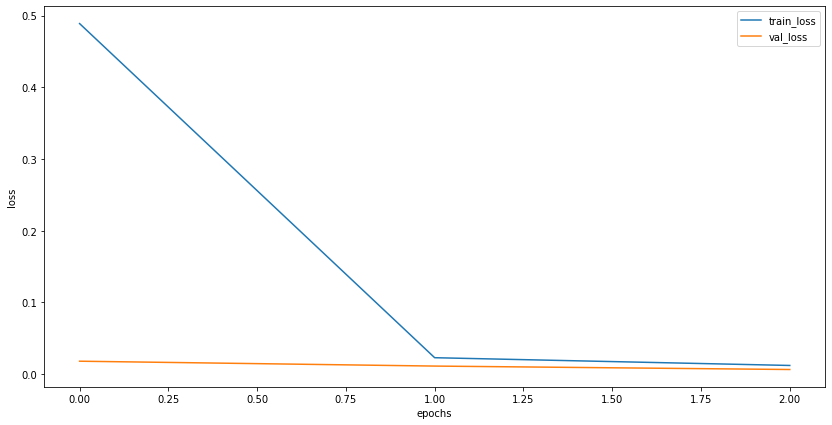

In [27]:
plt.figure(figsize=(14, 7))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

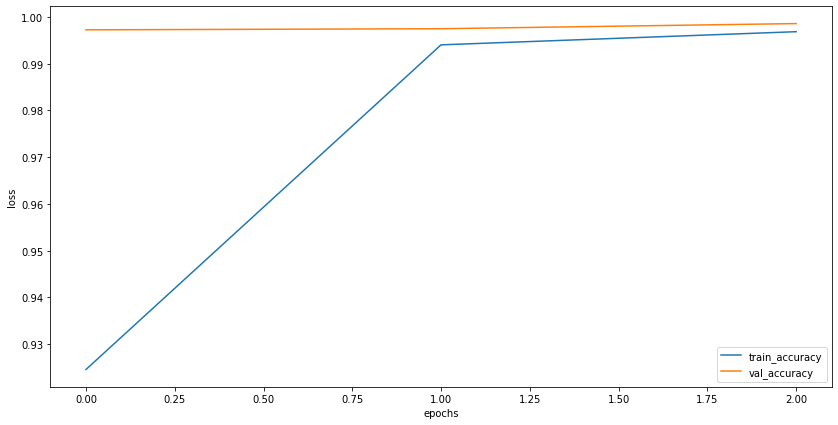

In [28]:
plt.figure(figsize=(14, 7))
plt.plot(acc, label="train_accuracy")
plt.plot(val_acc, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [0]:
idxs = random.sample(list(range(val_idxs)), 4000)
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model_rn, imgs)

In [30]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
[label_encoder.classes_]

[array(['abraham_grampa_simpson', 'agnes_skinner',
        'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
        'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum',
        'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel',
        'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson',
        'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
        'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson',
        'martin_prince', 'mayor_quimby', 'milhouse_van_houten',
        'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz',
        'otto_mann', 'patty_bouvier', 'principal_skinner',
        'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum',
        'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird',
        'troy_mcclure', 'waylon_smithers'], dtype='<U24')]

In [0]:
y_pred = np.argmax(probs_ims, -1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [32]:
# навскидку выходит неплохо
print(*actual_labels[::20])
print(*y_pred[::20])

41 28 11 24 36 19 12 40 5 13 3 24 13 3 7 20 21 21 26 4 21 15 19 15 22 13 5 9 11 8 34 1 13 13 27 33 17 18 14 2 12 36 29 8 34 40 26 14 36 30 34 37 0 35 11 28 9 33 18 19 12 39 30 5 7 6 19 20 35 2 8 38 15 26 8 10 11 13 33 22 38 38 14 40 0 37 29 39 18 15 4 17 15 41 11 39 3 14 15 39 13 11 31 12 5 35 31 8 36 13 21 21 17 23 35 10 33 7 33 12 41 3 39 11 38 19 31 1 41 38 7 23 39 39 30 38 36 40 32 5 23 23 27 37 7 15 0 22 31 0 5 18 22 6 12 14 4 8 26 18 12 34 14 4 36 39 12 1 16 18 23 14 15 36 10 20 15 23 30 29 18 19 14 39 12 25 11 8 3 9 40 7 29 18 0 9 23 23 24 8
41 28 11 24 36 19 12 40 5 13 3 24 13 3 7 20 21 21 26 0 21 15 19 15 22 13 5 9 11 8 34 1 13 13 27 33 17 18 14 2 12 36 29 8 34 40 26 14 36 30 34 37 0 35 11 28 9 33 18 19 12 39 30 5 7 6 19 20 35 2 8 38 15 26 8 10 11 13 33 22 38 38 14 40 0 37 29 39 18 15 4 17 15 41 11 39 3 14 15 39 13 11 31 12 5 35 31 8 36 13 21 21 17 23 35 10 33 7 33 12 41 3 39 11 38 19 31 1 41 38 7 23 39 39 30 38 36 40 32 5 23 23 27 37 7 15 0 22 31 0 5 18 22 6 12 14 4 8 26 18 1

Метрика — **f1-score**

In [33]:
from sklearn.metrics import f1_score
f1_score(actual_labels, y_pred, average='micro')

0.99875

In [34]:
# метрика mean f1 (score='macro')
mean_f1_score(actual_labels, y_pred)

0.9982185331631683

In [0]:
# делаем предсказания для тестовой выборки по обученной модели для всех 42 классов

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch)
probs = predict(model_rn, test_loader)

In [36]:
# получаем предсказаниекласса для каждого изображения тестовой выборки

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]
len(preds), type(preds), preds.shape

(991, numpy.ndarray, (991,))

In [37]:
# создаем файл для сабмита на каггл

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [0]:
# и сохраняем его

filename = 'colab_densenet161_Adam_b32_e3_balanced3'
my_submit.to_csv(filename + '.csv', index=False)

In [0]:
# сохраним модель

# параметры модели
torch.save(model_rn.state_dict(), filename + '.params')
# модель полностью
# torch.save(model_rn,
#            'colab_dencenet161_Adam_b16_e5_balanced3.model')

# the_model = TheModelClass(*args, **kwargs)
# the_model.load_state_dict(torch.load(path))
# the_model = torch.load(path)

In [0]:
# удаляем временную директорию
!rm -rf temp